# SCC-ICMC-USP - 1o. semestre de 2023
# SCC5948/MAI5024 - CIENCIA DE DADOS
## **Exercício 5**
##**CURVAS ROC**

### Profa. Roseli A. F. Romero

### Monitor: Diogo Godoi

Nro do grupo: 

Alunos:


1.    


#Curva ROC e Teste de hipótese

## Funções novas utilizadas no exercício

- `pandas.Series.nunique()` ([link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.nunique.html)): Conta quantidade de valores únicos de uma coluna. 
- `scipy.stats.ttest_ind()` ([link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)): Calcula o teste t para duas amostras independentes
- `sklearn.metrics.plot_roc_curve()` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html)): Plota a curva ROC de um classificador dado um conjunto de input e alvo

O DATASET A SER UTILIZADO É O TITANIC.CSV disponivel já disponivel na biblioteca pandas.

### Questão 01.

Faça a exploração dos dados. Isto é, carregue, substitua valores faltantes, padronize os dados, etc. Faça também a seleção dos atributos que achar mais relevantes. 

 - Dica: Utilize a função `nunique()` durante a exploração dos dados. Você pode utilizar o "bom senso" (além de outras ferramentas é claro) na hora de escolher qual atributo do conjunto manter

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
#df_train = pd.read_csv("train.csv")
#df_test = pd.read_csv("test.csv")
#df = pd.concat([df_test, df_train])
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [166]:
# Etapas de pré-processamento que podem ser feitas antes de separar em treino/teste vão aqui

# print('Missing values counts per column')
# print(df.isna().sum())
# display(df[df['Embarked'].isna()==True])

print('Decisions')
print('1. Age is hard to estimate or interpolate. Column removed.')
print('2. Embarked has only 2 rows missing the value, impact should be small. Rows removed.')
print('3. Cabin is also hard to estimate or interpolate. Column removed.')
if 'Age' in df.columns:
    df = df.drop(['Embarked', 'Age', 'Cabin'], axis=1)

print('4. FamilyName may indicate that members of the same family had greater chance to survive. Column added.')
if 'Name' in df.columns:
    df[['FamilyName', 'MainName']] = df['Name'].str.split(',', expand=True)

print('5. Name and Main Name does not add much information to the prediction. Columns removed.')
if 'Name' in df.columns:
    df = df.drop(['Name', 'MainName'], axis=1)

# Checking correlations:
# print(df[['Pclass', 'Fare']].corr())
# print(df[['Survived', 'FamilyName', 'Pclass', 'Fare', 'SibSp', 'Parch']].corr())
print('6. Correlations do not show good relations between survided and other columns.')

# print('Unique counts per column')
# print(df.nunique())
display(df)

Decisions
1. Age is hard to estimate or interpolate. Column removed.
2. Embarked has only 2 rows missing the value, impact should be small. Rows removed.
3. Cabin is also hard to estimate or interpolate. Column removed.
4. FamilyName may indicate that members of the same family had greater chance to survive. Column added.
5. Name and Main Name does not add much information to the prediction. Columns removed.
6. Correlations do not show good relations between survided and other columns.


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,FamilyName
0,1,0,3,male,1,0,A/5 21171,7.2500,Braund
1,2,1,1,female,1,0,PC 17599,71.2833,Cumings
2,3,1,3,female,0,0,STON/O2. 3101282,7.9250,Heikkinen
3,4,1,1,female,1,0,113803,53.1000,Futrelle
4,5,0,3,male,0,0,373450,8.0500,Allen
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,0,0,211536,13.0000,Montvila
887,888,1,1,female,0,0,112053,30.0000,Graham
888,889,0,3,female,1,2,W./C. 6607,23.4500,Johnston
889,890,1,1,male,0,0,111369,30.0000,Behr


In [175]:
# Etapas de pré-processamento que serão feitas após os dados estarem divididos em treino/teste
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

features_categoricos = ['Sex']
features_numericos = ['Fare']

print('Decisions')
print('7. Out of selected columns, only Fare is numerical. Normalized between 0 and 1.')
print('8. FamilyName and Sex are categorical columns. Transformed into classes by using One-Hot Encolding.')

# Splitting into train and test datasets
if 'Survived' in df.columns:
    y = df.pop('Survived')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=213)
y_test_raw = y_test.copy()
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

def preprocess(X_train, X_test, y_train, y_test, features_categoricos, features_numericos):
  numerical_pipeline = Pipeline(steps=[
      ('scaler', StandardScaler())])
  categorical_pipeline = Pipeline(steps=[
      ('onehot', OneHotEncoder())])
  transformer_ = ColumnTransformer(
      transformers=[
          ('Numerical', numerical_pipeline, features_numericos),
          ('Categorical', categorical_pipeline, features_categoricos),        
      ])
  
  df_transformer_train = transformer_.fit_transform(X_train)
  df_transformer_test = transformer_.fit_transform(X_test)

  numerical_columns = features_numericos
  categorical_columns = list(transformer_.transformers_[1][1].named_steps['onehot'].get_feature_names_out(features_categoricos))
  columns = numerical_columns + categorical_columns

  X_modf_train = pd.DataFrame(data = df_transformer_train, columns=columns)
  X_modf_test = pd.DataFrame(data = df_transformer_test, columns=columns)

  X_modf_test.reset_index()
  X_modf_test.reset_index()
  
  X_modf_train = pd.merge(X_train, X_modf_train, left_index=True, right_index=True, how='outer')
  X_modf_test = pd.merge(X_test, X_modf_test, left_index=True, right_index=True, how='outer')
  
  X_modf_train = X_modf_train[['Pclass', 'SibSp', 'Parch', 'Fare_y', 'Sex_female', 'Sex_male']]
  X_modf_test = X_modf_test[['Pclass', 'SibSp', 'Parch', 'Fare_y', 'Sex_female', 'Sex_male']]

  return X_modf_train, X_modf_test, y_train, y_test


X_modf_train, X_modf_test, y_train, y_test = preprocess(X_train, X_test, y_train, y_test, features_categoricos, features_numericos)
display(X_modf_train)



Decisions
7. Out of selected columns, only Fare is numerical. Normalized between 0 and 1.
8. FamilyName and Sex are categorical columns. Transformed into classes by using One-Hot Encolding.


,Pclass,SibSp,Parch,Fare_y,Sex_female,Sex_male
0,3,4,2,-0.029820,1.0,0.0
1,3,2,0,-0.228841,0.0,1.0
2,1,0,0,2.330429,1.0,0.0
3,1,0,0,-0.128989,1.0,0.0
4,3,3,1,-0.151197,0.0,1.0
...,...,...,...,...,...,...
707,3,0,0,-0.178189,0.0,1.0
708,1,1,0,0.788050,1.0,0.0
709,2,0,0,-0.406766,0.0,1.0
710,2,0,0,-0.406766,0.0,1.0


### Questão 02.

Separe o conjunto de dados de maneira estratificada (através do parâmetro `stratify` da função `train_test_split`) em 20% para teste e 80% para treino. Depois plote a curva ROC (`sklearn.metrics.plot_roc_curve`) para **todos** os classificadores (no mesmo gráfico). 

Os melhores classificadores da questão anterior também apresentaram melhor desempenho na curva ROC? O que pode ter ocorrido? Teste diferentes valores de `random_state` na função `train_test_split` e observe o comportamento das curvas.


*   Dica: Para plotar múltiplas curvas ROC no mesmo gráfico, defina uma figura com `fig, ax = plt.subplots()` e passe `ax` como parâmetro da função `plot_roc_curve`. Não se esqueça de passar também o nome do classificador para que o seu gráfico fique mais fácil de interpretar



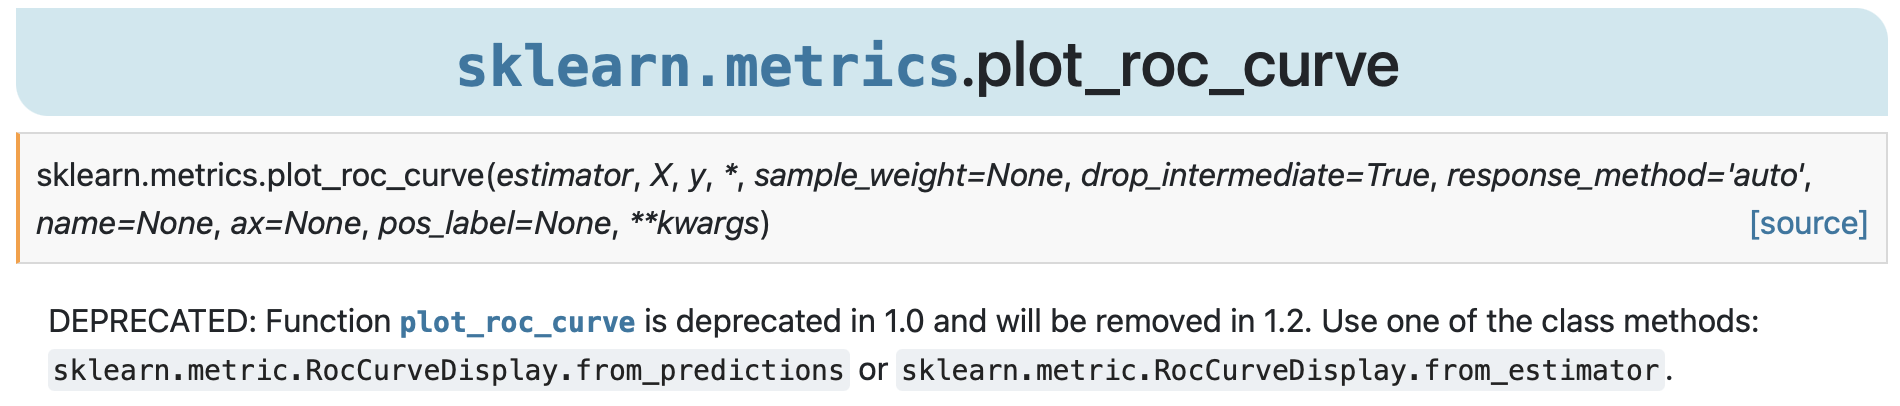

In [173]:
def confusion_matrix(y_test, y_pred):
  unique_labels = np.unique(np.concatenate((y_test, y_pred)))
  num_labels = len(unique_labels)
  conf = np.zeros((num_labels, num_labels))
  for i in range(len(y_test)):
      conf[int(y_test[i]), int(y_pred[i])] += 1
  return conf

def accuracy(conf):
  VP, VN = conf[0,0], conf[1, 1]
  accuracy_result = (VP+VN)/np.sum(conf)
  return accuracy_result

def f1_score(conf):
  VP, VN, FP, FN = conf[0,0], conf[1, 1], conf[1,0], conf[0,1]
  recall = VP/(VP+FN)
  TVN = VN/(VN+FP)
  f1_result = np.round(2/((1/recall)+(1/TVN)),2)
  return f1_result


Perceptron
Acurácia: 0.74
F1 Score: 0.61
-----------------------------
Multi-Layer Perceptron (15,)
Acurácia: 0.78
F1 Score: 0.73
-----------------------------
Árvore Decisão Critério Gini
Acurácia: 0.78
F1 Score: 0.73
-----------------------------
KNN k=5
Acurácia: 0.82
F1 Score: 0.8
-----------------------------


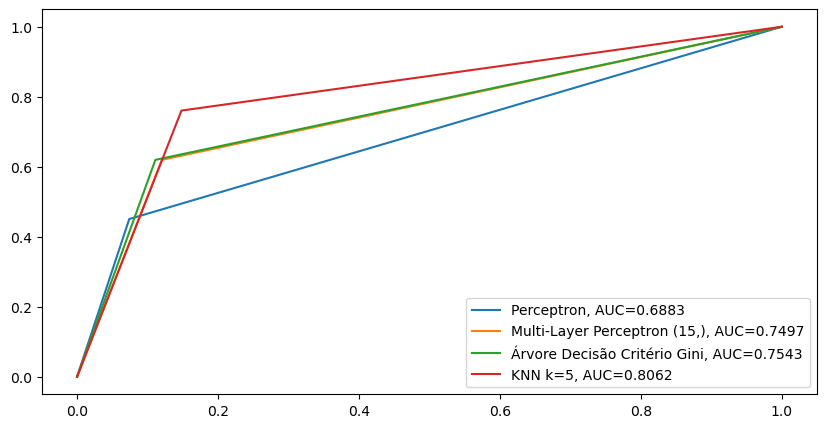

In [176]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, metrics
import numpy as np

classificadores = {
  "Perceptron" : {"modelo": Perceptron(), "scores": []},
  "Multi-Layer Perceptron (15,)" : {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000), "scores": []},
  "Árvore Decisão Critério Gini" : {"modelo": DecisionTreeClassifier(criterion='gini'), "scores": []},  
  "KNN k=5" : {"modelo": KNeighborsClassifier(n_neighbors=5), "scores": []}
}

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
for classificador_name in classificadores:
    print(classificador_name)
    c = classificadores[classificador_name]['modelo']
    clf = c.fit(X=X_modf_train, y=y_train)

    # valores preditos pelo classificador
    y_pred = clf.predict(X_modf_test)
    # rótulos verdadeiros convertidos para array
    y_test = np.array(y_test)
    
    # realiza predição no conjunto de teste e salva o resultado
    ####
    conf_mat = confusion_matrix(y_test, y_pred)
    resultado = np.round(accuracy(conf_mat),2)
    print('Acurácia:', resultado)
    resultado = f1_score(conf_mat)
    print('F1 Score:', resultado)
    print('-----------------------------')
    #roc = metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    ax.plot(fpr,tpr,label=classificador_name+ ", AUC="+str(auc))
    ax.legend()
      
 # seu código aqui
 
plt.show() 


For random_state = 123
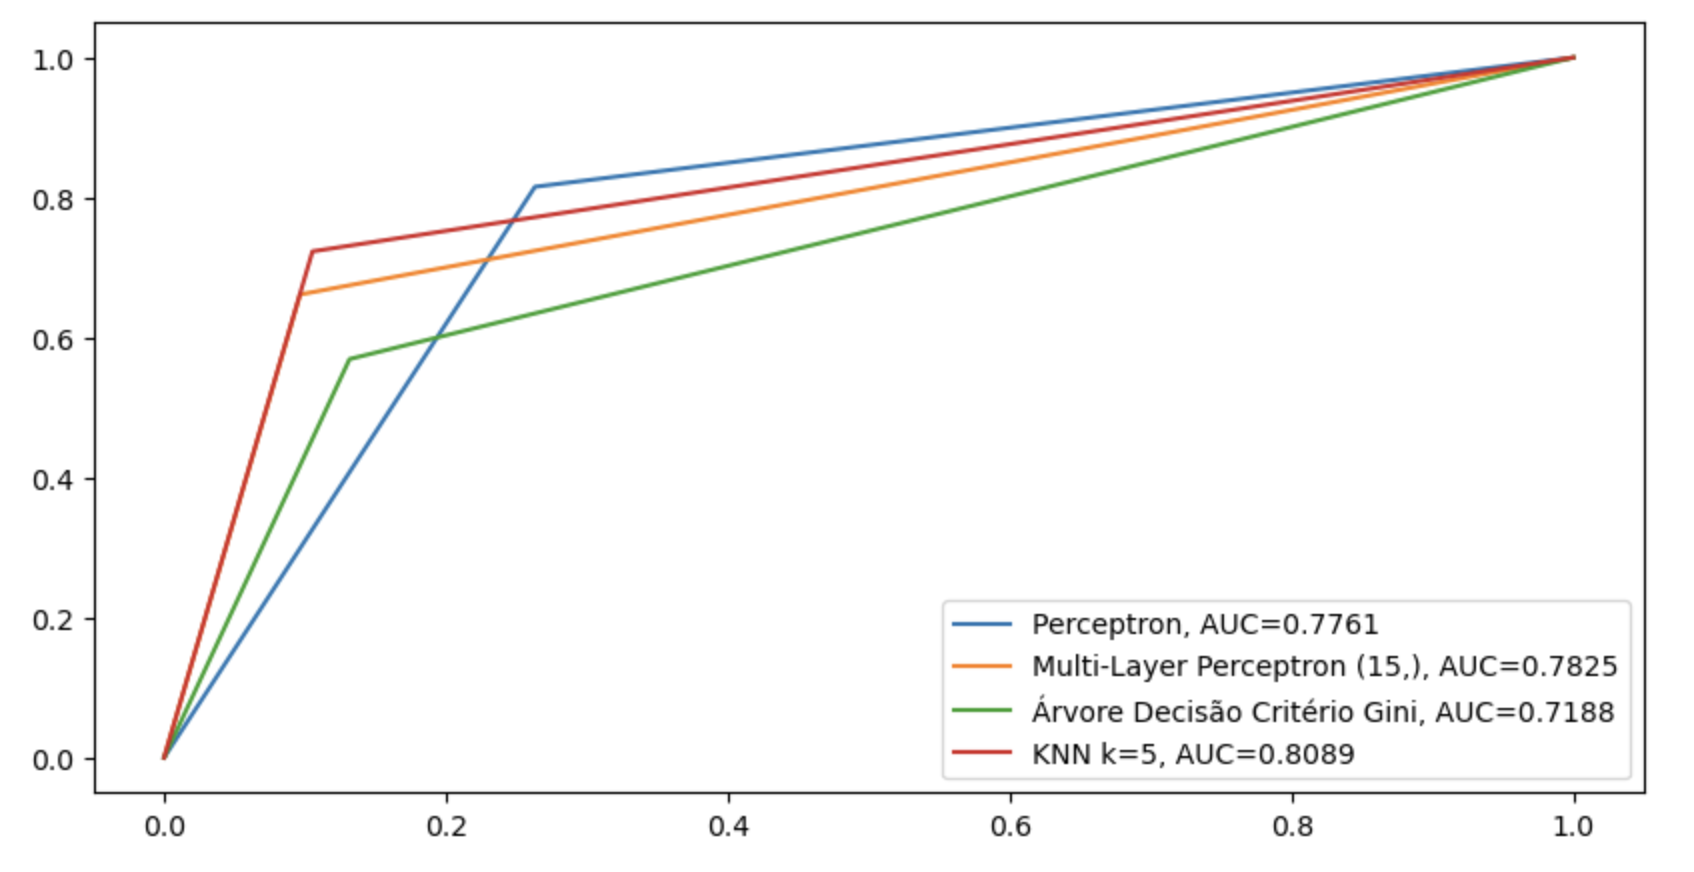

For random_state = 321
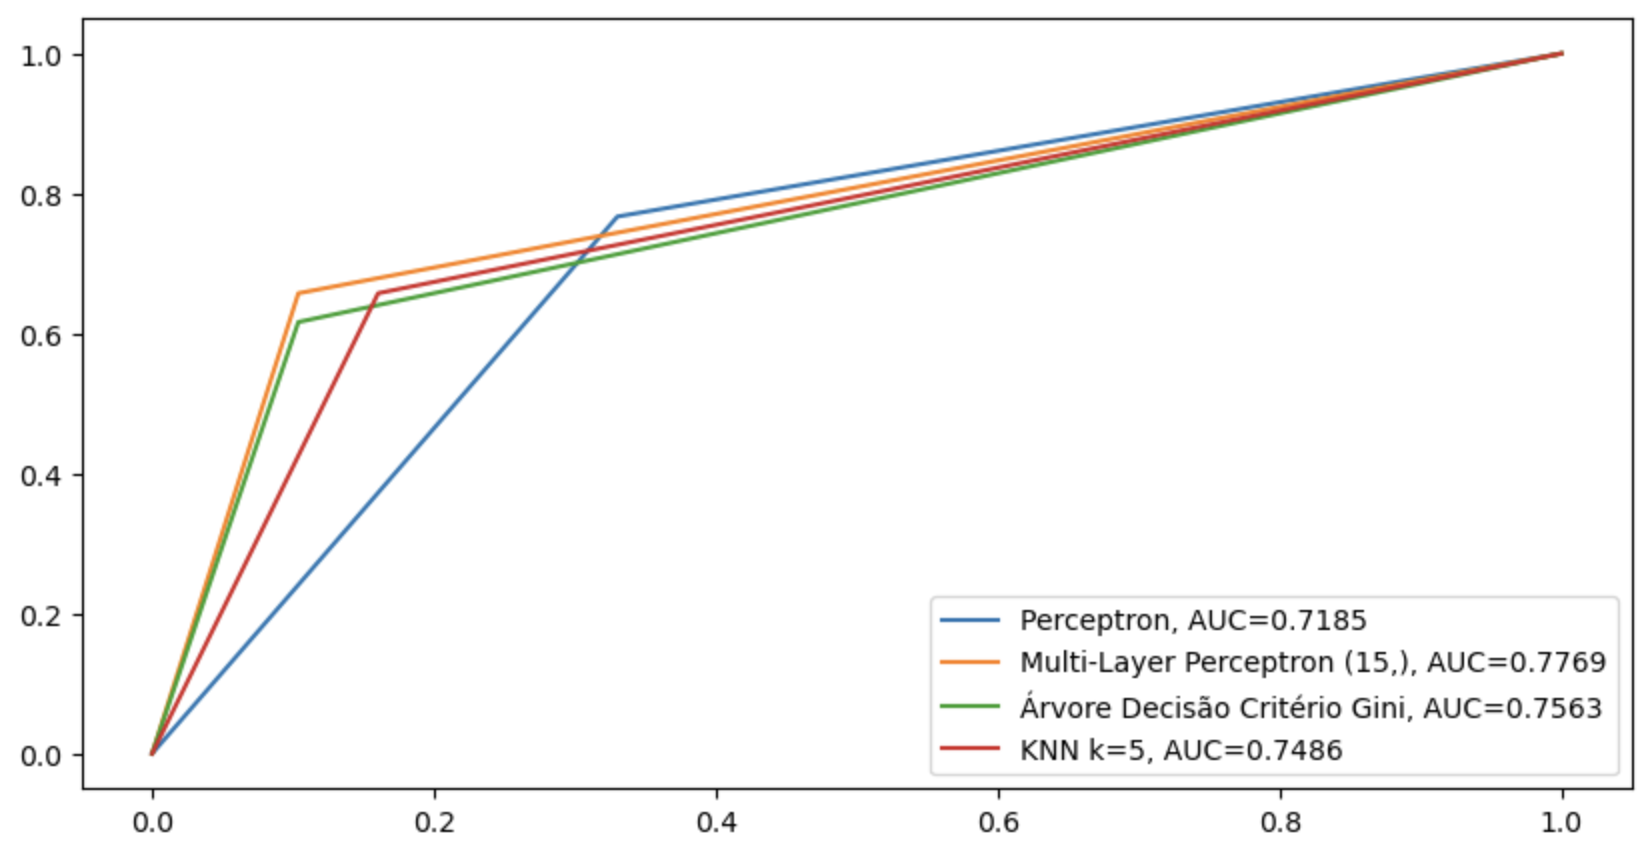

For random_state = 213
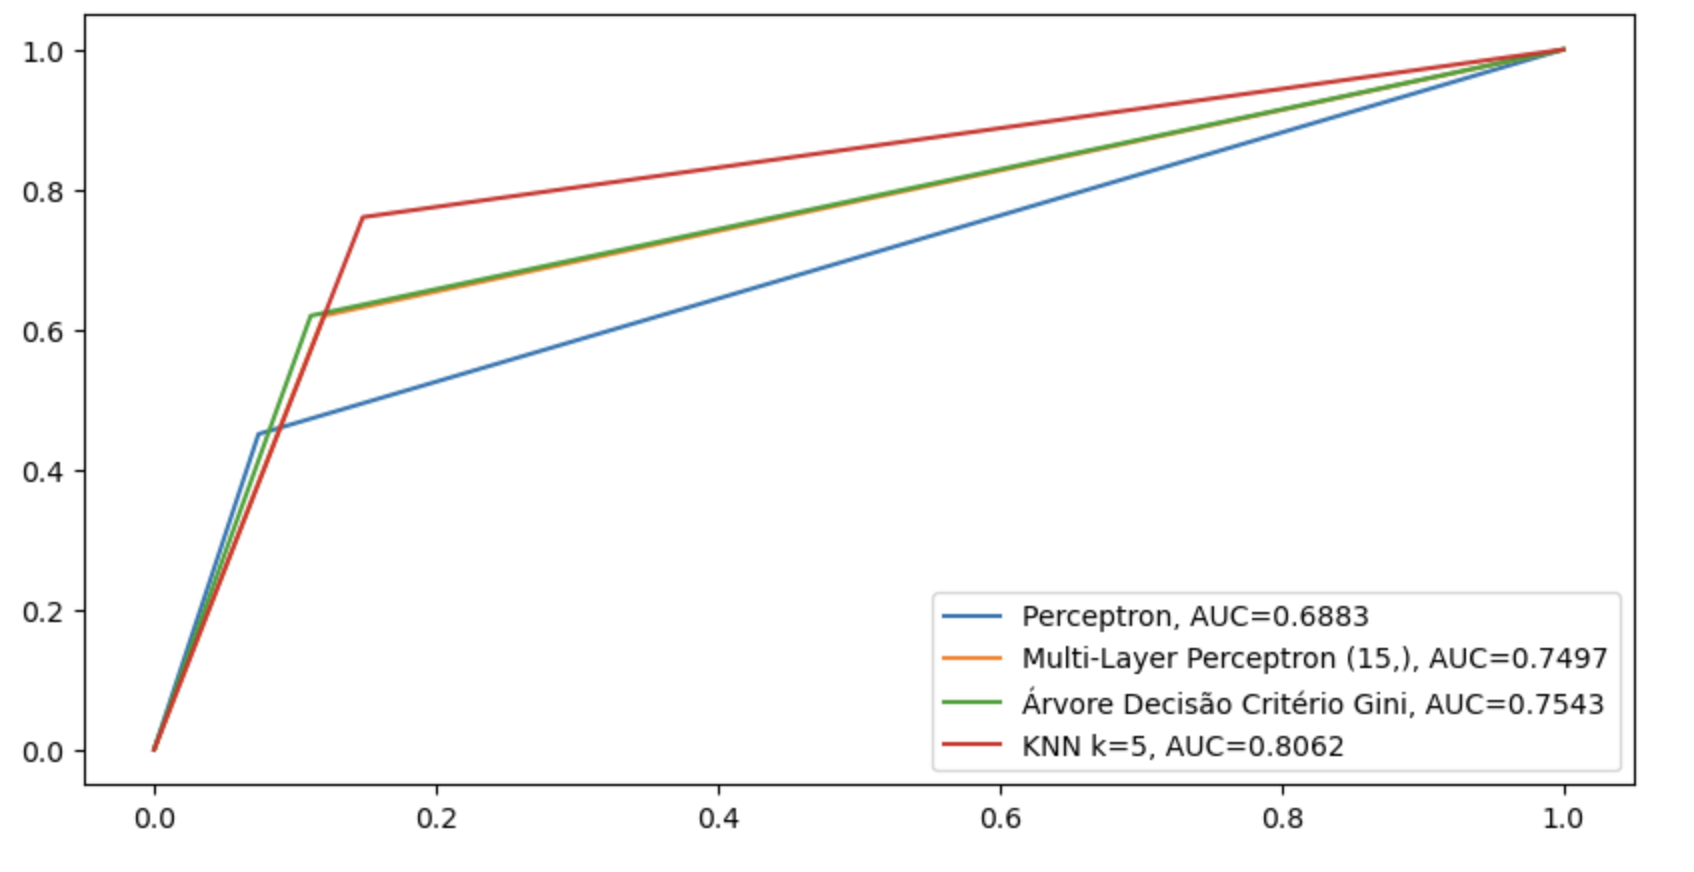


By running the algorithm with different random_state values for train/test split, we got slightly different results for the AUC curves.
My conclusion is that, some randomly selected values selected for training, made a better representation of the dataset behaviour than others, thus leading to a better model (better results on validation).

### Questão 03.

Implemente o 10-Fold Cross Validation (pode usar o scikit) com os dois melhores classificadores de acordo com a curva ROC e guarde a acurácia de cada fold na chave 'scores' do dicionário de classificadores.

In [188]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
x_data = pd.concat([X_modf_train, X_modf_test])
x_data.reset_index(drop=True, inplace=True)
y_data = pd.concat([y_train, y_test_raw])
y_data.reset_index(drop=True, inplace=True)

for classificador_name in classificadores:
    classificadores[classificador_name]['scores'] = []
    if classificador_name != 'Perceptron' and classificador_name != 'KNN k=5':
        continue
    for train_index, test_index in kfold.split(x_data):
        x_train = x_data.loc[train_index]
        x_test = x_data.loc[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        
        c = classificadores[classificador_name]['modelo']
        clf = c.fit(X=x_train, y=y_train)

        # valores preditos pelo classificador
        y_pred = clf.predict(x_test)
        # rótulos verdadeiros convertidos para array
        y_test = np.array(y_test)
        
        conf_mat = confusion_matrix(y_test, y_pred)
        resultado = np.round(accuracy(conf_mat),2)
        classificadores[classificador_name]['scores'].append(resultado)

    print(classificador_name, classificadores[classificador_name]['scores'])

Perceptron [0.59, 0.56, 0.4, 0.35, 0.54, 0.45, 0.62, 0.27, 0.78, 0.63]
KNN k=5 [0.53, 0.55, 0.57, 0.53, 0.53, 0.54, 0.64, 0.66, 0.54, 0.56]


### Questão 04.

Verifique se há diferença estatística significante entre suas acurácias da questão anterior utilizando o teste T (`scipy.stats.ttest_ind`). Considere que há diferença significante se p <= 0.05 (rejeita-se a hipótese nula)

In [191]:
from scipy.stats import ttest_ind
ttest_result = ttest_ind(classificadores['Perceptron']['scores'], classificadores['KNN k=5']['scores'])
print('p-value = ', ttest_result.pvalue, ' > 0.05 -> hipótese nula aceita')

p-value =  0.37195214165573176  > 0.05 -> hipótese nula aceita
